Following explore data which created the arbitrary label and dataset splits, in this notebook I will prepare the PyTorch dataset and dataloader objects, along with the requisite pre-processing of each. 

In [1]:
import sys
sys.path.append('../dat/')

from collect_and_prepare_data import prepare_data

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
coin_train, coin_valid, coin_test, today, res = prepare_data(prior_years=5,crypto='bitcoin',values='usd', buy_thresh = 5, window = 7)

Text(0.5, 1.0, '0.002913481178064668')

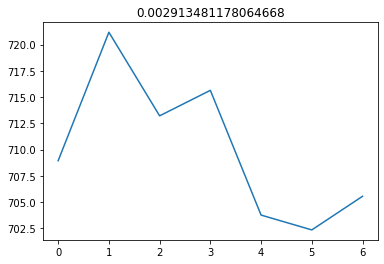

In [5]:
plt.plot(coin_train[4]['prices'])
plt.title(coin_train[4]['pct_change'])

In [20]:
idx = 4
X = coin_train[idx]['prices']




In [25]:
X_scaled = (X - X.min()) / (X.max() - X.min())

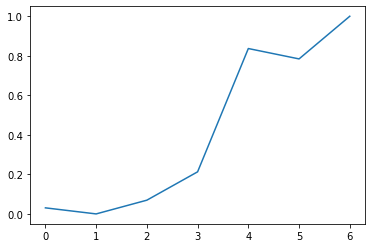

In [26]:
plt.plot(X_scaled)

In [27]:
X_norm = (X_scaled - X_scaled.mean()) / X_scaled.std()

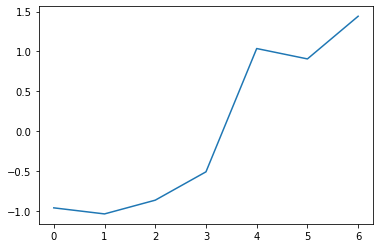

In [31]:
plt.plot(X_norm)

In [32]:
import torch

In [19]:
from torch.utils.data import Dataset



In [35]:
# class 

# load dataloaders


class CryptoDataset(Dataset):
    """
    Dataset class for crypto data. 
    
    Reads in the list of historical weeks and depending on label to load (currently either pct_change or 'y') 
    returns those as a vector to pair with input week of prices X. 
    
    Current pre-processing step done within this class is to min-max scale the input X, and then normalize.
    
    Idea is gaussian input, roughly gaussian output (pct changes are kinda around that)
    
    Open to suggestions. 
    
    
    """
    def __init__(self, coin_file,label_to_load = ['pct_change'],scale = True):
        self.coin_file = coin_file
        self.label_to_load = label_to_load

    def __len__(self):
        return len(self.coin_file)

    def __getitem__(self, idx):
        
        X = self.coin_file[idx]['prices']
        X_scaled = (X - X.min()) / (X.max() - X.min())
        X_norm = torch.Tensor((X_scaled - X_scaled.mean()) / X_scaled.std())
        
        
        y = []
        for label in self.label_to_load:
            y.append(self.coin_file[idx][label])
            
        
        # TODO - return date as well? Do I think I'll even care? 
        
        return X_norm, torch.Tensor(y)
        

In [46]:
train_dataset = CryptoDataset(coin_train,['pct_change'])

Now to instantiate the dataloader. 

In [47]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [48]:
for batch in train_dataloader:
    break

(array([ 1.,  6., 12., 12., 19.,  8.,  4.,  0.,  1.,  1.]),
 array([-15.94749641, -11.85281296,  -7.7581295 ,  -3.66344604,
          0.43123741,   4.52592087,   8.62060432,  12.71528778,
         16.80997124,  20.90465469,  24.99933815]),
 <BarContainer object of 10 artists>)

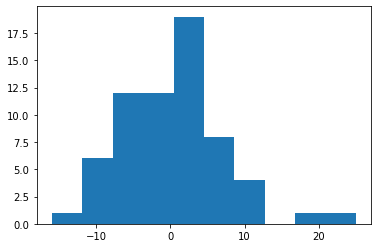

In [64]:
plt.hist(batch[1][:,0].flatten().tolist(),bins=10)

Vaguely gaussian haha. This model will perform terribly.

Now to cap off, let's create a prepare_data object which returns the 3 dataloaders, to then be inserted into all of the lightning training stuff. 

In [67]:
def create_dataloaders(prior_years,crypto,values,buy_thresh,window,batch_size,labels_to_load):
    """
    Runs full data loading and preparation pipeline to allow me to experiment with all aspects of
    the datasets as part of training. 

    
    
    """
    
    
    coin_train, coin_valid, coin_test = prepare_data(prior_years=prior_years,
                                                    crypto=crypto,values=values, 
                                                    buy_thresh = buy_thresh, 
                                                     window = window)
    
    
    train_dataset = CryptoDataset(coin_train,labels_to_load)
    valid_dataset = CryptoDataset(coin_valid,labels_to_load)
    test_dataset = CryptoDataset(coin_test,labels_to_load)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    
    
    return train_loader, valid_loader, test_loader

In [68]:
create_dataloaders(prior_years=10,crypto='btc',values='usd',buy_thresh=10,window=7,batch_size=32,labels_to_load = ['pct_change'])

(<torch.utils.data.dataloader.DataLoader at 0x7fbdd5915460>,
 <torch.utils.data.dataloader.DataLoader at 0x7fbdd5ab6fa0>)